In [60]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [61]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

In [62]:
function sse(prediction::AbstractVector, test_data::AbstractVector) 
    return sum.((prediction .- test_data).^2)
end

sse (generic function with 2 methods)

In [63]:
data = Matrix(CSV.read("data/sst_data/sst_34_anomaly_embedded.txt", DataFrame; delim=',', ignorerepeated=true, header=false));

In [64]:
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.08,0.1, 0.12, 0.14, 0.2]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [90, 110, 120, 125, 130, 135, 140, 150, 160, 180, 190, 200, 210]
param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [65]:
data_train = data[1:395,:]'; # train data is kept fixed to 80%

5×395 adjoint(::Matrix{Float64}) with eltype Float64:
  0.08  -0.2   -0.14   0.02   0.49  …  -0.03  -0.01   0.31   0.43   0.75
  0.27   0.86   1.24   1.73   1.68      0.51   0.75   0.44   0.82   0.83
  2.13   1.81   1.22   0.68   0.68      1.26   1.65   1.79   2.21   2.72
 -0.33  -0.44  -0.38  -1.02  -1.29      2.47   2.23   1.61   0.98   0.27
 -0.96  -0.16  -0.52  -0.54  -0.69     -0.42  -0.49  -0.43  -0.7   -0.64

In [66]:
# sample size N
N = 20

# lead time L
L = 30

sse_vals = zeros(N,L); # store sse of predictions vs true for prediction startet at different time step -> later rmse along dimension 1

In [67]:
for n in 1:N
    println("n=$n")
    val_data = data[396:395+n+48 , :]' # start validation set of length 48+n
    test_data = data[395+n+49:395+n+48+L,:]' # test against L month forecast lead
    esn, W_out, val_loss = enso_project.cross_validate_esn(data_train, val_data, param_grid) 
    prediction = enso_project.esn_eval_pred(esn, W_out, test_data)
    sse_vals[n,:] .= sse(prediction, test_data[1,:])
end

n=1
enso_project

.ESNHyperparams(90, 0.8, 0.05, 0.1, 0.0)
Validation loss = 165.89071796388623
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 125.74689246733459
enso_project.ESNHyperparams(110, 0.9, 0.05, 0.1, 0.0)
Validation loss = 102.28493453843394
enso_project.ESNHyperparams(180, 0.9, 0.05, 0.1, 0.0)
Validation loss = 81.93028582436975
enso_project.ESNHyperparams(90, 1.0, 0.1, 0.1, 0.0)
Validation loss = 74.17290271260012
enso_project.ESNHyperparams(90, 0.9, 0.12, 0.1, 0.0)
Validation loss = 54.501160344104136
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 0.0)
Validation loss = 30.50979942909385
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 1.0e-6)
Validation loss = 30.49596650913812
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 1.0e-5)
Validation loss = 30.42386160998865
n=2
enso_project.ESNHyperparams(90, 0.8, 0.05, 0.1, 0.0)
Validation loss = 171.4474097332627
enso_project.ESNHyperparams(150, 0.8, 0.05, 0.1, 0.0)
Validation loss = 128.41675444018466
enso_project

In [68]:
# compute RMSE
rmse = sqrt.(sum(sse_vals, dims=1) ./N)

1×30 Matrix{Float64}:
 0.0361066  0.0464942  0.0463467  0.0390568  …  0.638692  0.753243  0.859485

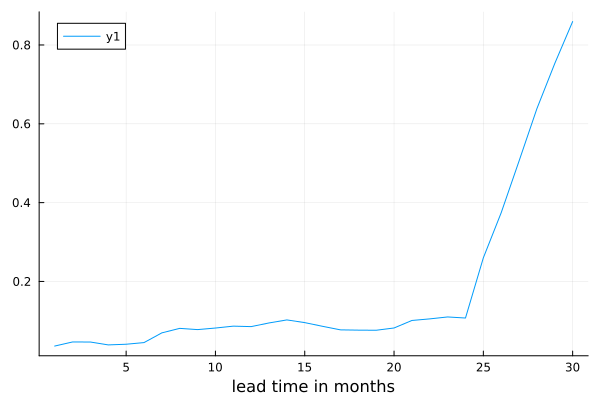

In [69]:
plot(rmse[1,:], xlabel="lead time in months")

In [70]:
CSV.write("C:/Users/lisah/Documents/Repos/enso_project.jl/error_saves/esn_L$(L)_N$N.csv", DataFrame(rmse, :auto))

"C:/Users/lisah/Documents/Repos/enso_project.jl/error_saves/esn_L30_N20.csv"